# CMPINF 2120 
# Bayesian Inference

In [1]:
pip install pymc3

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install arviz

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import pylab

import pymc3 as pm
import arviz as az

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


### Acceleration due to gravity on Earth 2

Read in dataset

In [4]:
df = pd.read_csv('duplicate-earth-displacement.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   time          100 non-null    float64
 1   time^2        100 non-null    float64
 2   displacement  100 non-null    float64
dtypes: float64(3)
memory usage: 2.5 KB


In [6]:
df.head()

,time,time^2,displacement
0,0.000000,0.000000,-0.022860
1,0.010101,0.000102,0.579796
2,0.020202,0.000408,-0.054100
3,0.030303,0.000918,-0.036855
4,0.040404,0.001632,-0.116797


In [7]:
x_1 = df.time

In [8]:
x_1

0     0.000000
1     0.010101
2     0.020202
3     0.030303
4     0.040404
        ...   
95    0.959596
96    0.969697
97    0.979798
98    0.989899
99    1.000000
Name: time, Length: 100, dtype: float64

In [9]:
x_2 = df.loc[:, ['time^2']]

In [10]:
x_2

,time^2
0,0.000000
1,0.000102
2,0.000408
3,0.000918
4,0.001632
...,...
95,0.920824
96,0.940312
97,0.960004
98,0.979900


In [11]:
y = df.displacement

In [12]:
y

0     -0.022860
1      0.579796
2     -0.054100
3     -0.036855
4     -0.116797
        ...    
95     9.990839
96    10.497322
97     7.900575
98    12.782528
99    13.724198
Name: displacement, Length: 100, dtype: float64

#### Scatterplots

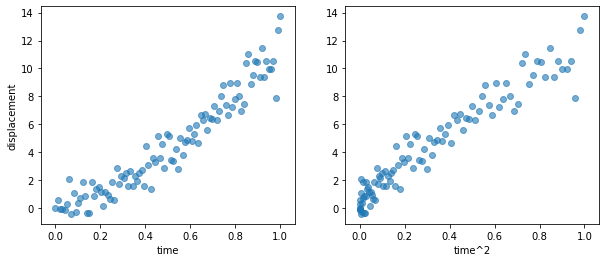

In [13]:
fig, axes = pylab.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(x_1, y, alpha=0.6)
axes[1].scatter(x_2, y, alpha=0.6)
axes[0].set_ylabel("displacement")
axes[0].set_xlabel("time")
axes[1].set_xlabel("time^2");

#### Non-Bayesian linear regression

In [14]:
from sklearn.linear_model import LinearRegression

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method

In [15]:
X = df.loc[:, ['time', 'time^2']]

In [16]:
regressor = LinearRegression()

In [17]:
regressor.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [18]:
print(regressor.coef_)

[4.01322277 7.63280745]


$ X = 4.0132 t + 7.6328 t^2$

$\alpha = 2 * 7.6328 = 15.2656$

#### Bayesian Model Specification

In [19]:
basic_model = pm.Model()

In [20]:
with basic_model:

    # Priors for unknown model parameters
    v_0 = pm.Normal("v_0", mu=4, sigma=1)
    alpha = pm.Normal("alpha", mu=9.8, sigma=1)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = v_0 * x_1 + 0.5* alpha * x_2

    # Likelihood (sampling distribution) of observations
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

In [21]:
map_estimate = pm.find_MAP(model=basic_model)
map_estimate

{'v_0': array(10.23207598),
 'alpha': array(-1.68787747),
 'sigma_log__': array(0.183221),
 'sigma': array(1.20107982)}

$ X = 10.232  t + \frac{1}{2} (-1.6878) t^2 \pm 1.2 $

$ \alpha = -1.6878$

#### Sampling the Posterior Distribution

In [22]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(500, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, v_0]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 21 seconds.


In [26]:
trace["alpha"][-5:]

array([-1.62498169, -1.61050102, -1.65843101, -1.70911991, -1.70735362])

In [23]:
az.style.use("arviz-darkgrid")

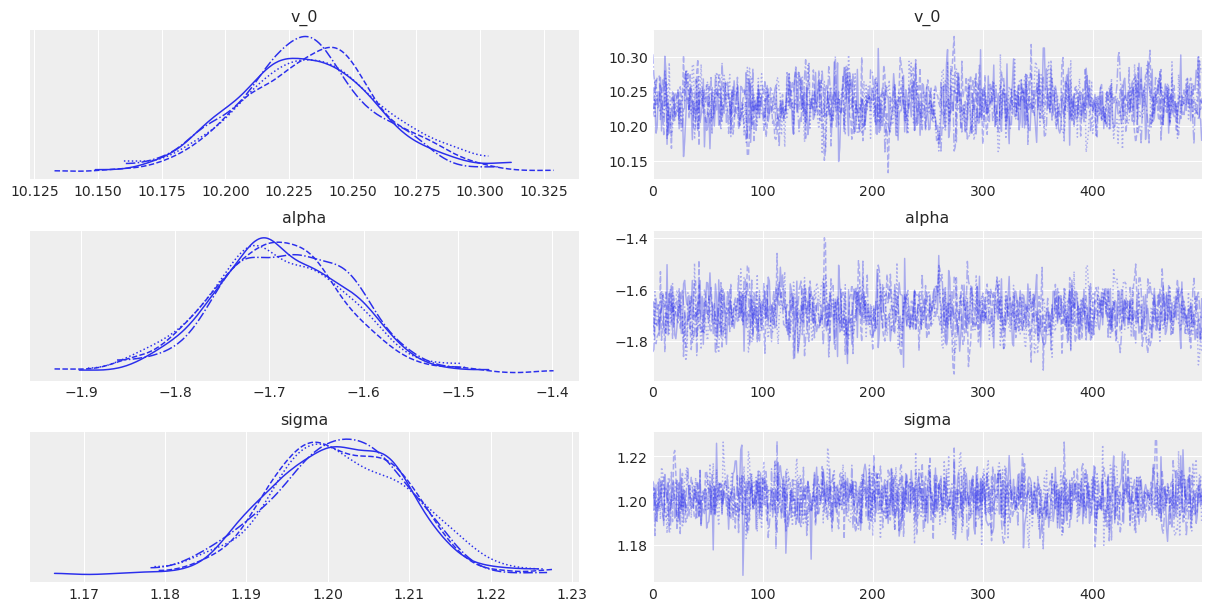

In [24]:
with basic_model:
    az.plot_trace(trace)

In [25]:
with basic_model:
    display(az.summary(trace, round_to=2))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v_0,10.23,0.03,10.18,10.28,0.0,0.0,1050.86,1432.88,1.0
alpha,-1.69,0.07,-1.82,-1.55,0.0,0.0,996.00,1302.52,1.0
sigma,1.20,0.01,1.19,1.22,0.0,0.0,1756.17,1354.01,1.0


CI for $\alpha$ is $[-1.82, -1.55]$

### Volcanic eruptions on Earth 2